__Import Libraries__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.metrics import classification_report,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

__Loaded Dataset__

In [2]:
df=pd.read_csv('heart.csv')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


__Checking Missing Values__


In [3]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

__Duplicate values__

In [4]:
df_dup=df.duplicated().any()
df_dup

True

In [5]:
df=df.drop_duplicates()
df_dup=df.duplicated().any()
df_dup

False

__Data Processing__

In [6]:
continuous_features=['age','trestbps','chol','thalach','oldpeak']
features_to_convert=[feature for feature in df.columns if feature not in continuous_features]
df[features_to_convert]=df[features_to_convert].astype('object')
df.dtypes

C:\Users\Dell\AppData\Local\Temp\ipykernel_8952\3122779442.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[features_to_convert]=df[features_to_convert].astype('object')


age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs          object
restecg      object
thalach       int64
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
target       object
dtype: object

In [7]:
# Calculate Q1, Q3, and IQR for each continuous feature
Q1 = df[continuous_features].quantile(0.25)
Q3 = df[continuous_features].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers for each continuous feature
outliers = ((df[continuous_features] < (Q1 - 1.5 * IQR)) | (df[continuous_features] > (Q3 + 1.5 * IQR)))

# Count the number of outliers in each continuous feature
outliers_count_specified = outliers.sum()

# Display the count of outliers for each feature
print("Outlier Counts for Each Feature:")
print(outliers_count_specified)

Outlier Counts for Each Feature:
age         0
trestbps    9
chol        5
thalach     1
oldpeak     5
dtype: int64


__One Hot Encoding__


In [8]:
import pandas as pd

# Apply one-hot encoding on specific categorical features
df_encoded = pd.get_dummies(df, columns=['cp', 'restecg', 'thal'], drop_first=True)

# Convert specified categorical variables to integer type
features_to_convert = ['sex', 'fbs', 'exang', 'slope', 'ca', 'target']
for feature in features_to_convert:
    df_encoded[feature] = df_encoded[feature].astype(int)

# Display the data types of all columns in the encoded DataFrame
print("Data Types of Encoded DataFrame Columns:")
print(df_encoded.dtypes)

Data Types of Encoded DataFrame Columns:
age            int64
sex            int32
trestbps       int64
chol           int64
fbs            int32
thalach        int64
exang          int32
oldpeak      float64
slope          int32
ca             int32
target         int32
cp_1            bool
cp_2            bool
cp_3            bool
restecg_1       bool
restecg_2       bool
thal_1          bool
thal_2          bool
thal_3          bool
dtype: object


In [9]:
df_encoded.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,0,1,False,False,True,False,False,True,False,False
1,37,1,130,250,0,187,0,3.5,0,0,1,False,True,False,True,False,False,True,False
2,41,0,130,204,0,172,0,1.4,2,0,1,True,False,False,False,False,False,True,False
3,56,1,120,236,0,178,0,0.8,2,0,1,True,False,False,True,False,False,True,False
4,57,0,120,354,0,163,1,0.6,2,0,1,False,False,False,True,False,False,True,False


__Spilting Dataset__

In [10]:
# Define features and labels
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

In [11]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [12]:
# Adding a small constant to 'oldpeak' to ensure all values are positive
X_train.loc[:, 'oldpeak'] = X_train['oldpeak'] + 0.001
X_test.loc[:, 'oldpeak'] = X_test['oldpeak'] + 0.001


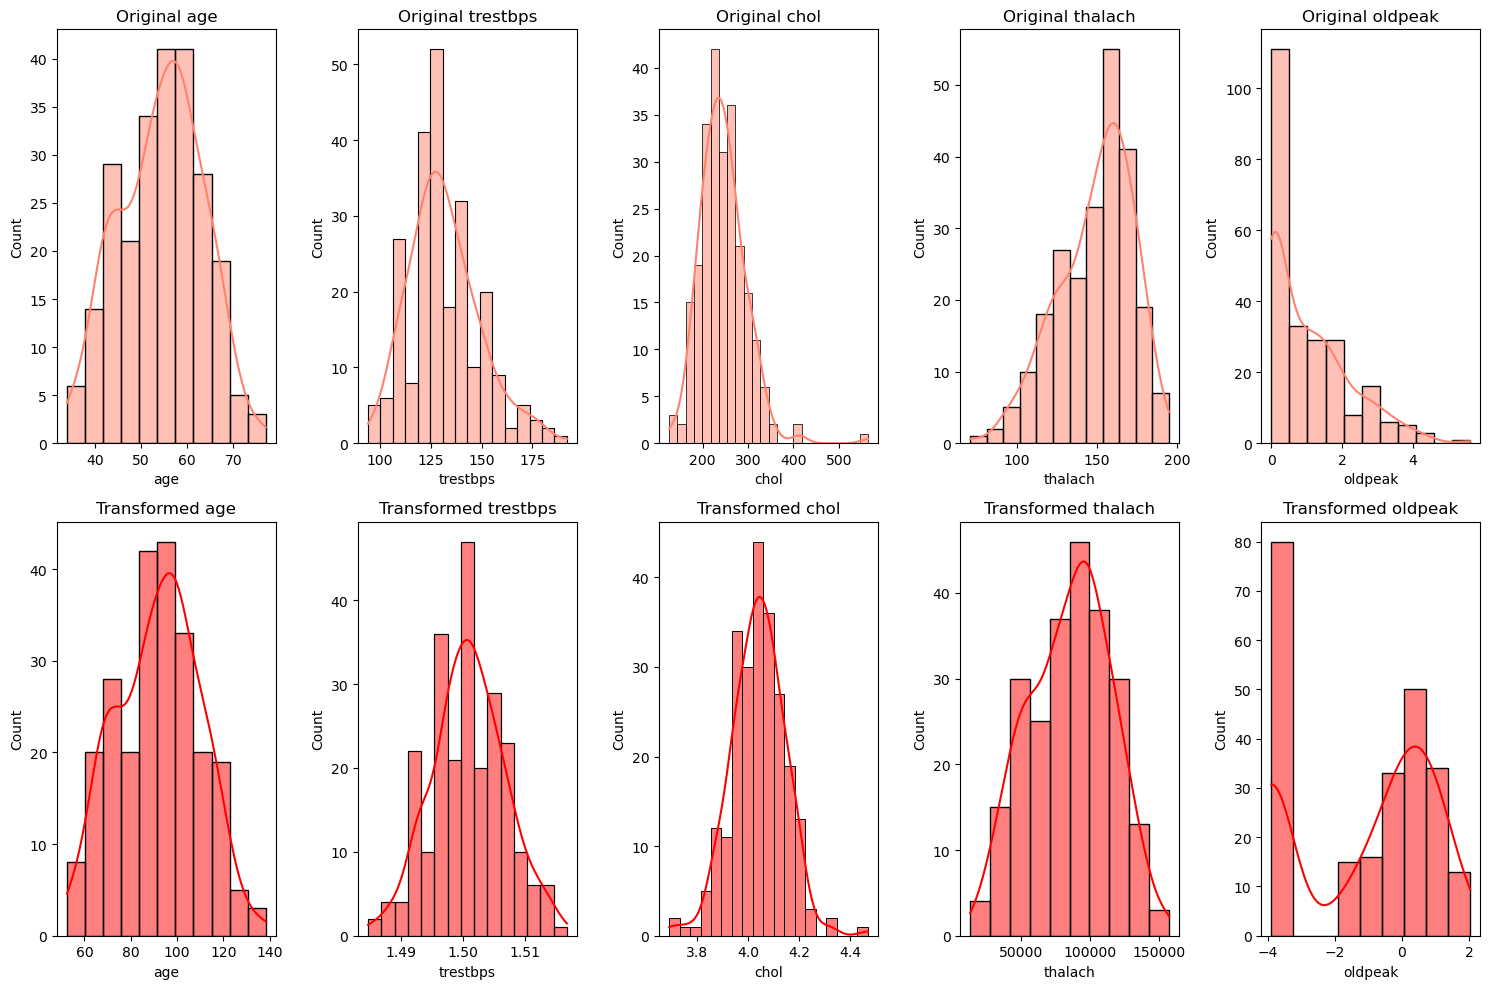

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox

# Checking the distribution of the continuous features
fig, ax = plt.subplots(2, 5, figsize=(15, 10))

# Dictionary to store lambda values for each feature
lambdas = {}

# Original Distributions
for i, col in enumerate(continuous_features):
    sns.histplot(X_train[col], kde=True, ax=ax[0, i], color='#ff826e').set_title(f'Original {col}')

# Applying Box-Cox Transformation
for i, col in enumerate(continuous_features):
    # Only apply Box-Cox for positive values
    if X_train[col].min() > 0:
        X_train[col], lambdas[col] = boxcox(X_train[col])
        X_test[col] = boxcox(X_test[col], lmbda=lambdas[col])  # Apply the same transformation to test data
        sns.histplot(X_train[col], kde=True, ax=ax[1, i], color='red').set_title(f'Transformed {col}')
    else:
        sns.histplot(X_train[col], kde=True, ax=ax[1, i], color='green').set_title(f'{col} (Not Transformed)')

fig.tight_layout()
plt.show()

In [14]:
X_train.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
269,94.886555,1,1.501070,4.128690,1,33182.245330,1,0.491743,0,0,False,False,False,False,False,False,False,True
191,98.909012,1,1.500366,3.987127,0,59642.423635,1,0.849443,1,3,False,False,False,False,False,False,False,True
15,82.970802,0,1.497357,3.994464,0,94189.755213,0,0.491743,1,0,False,True,False,True,False,False,True,False
224,90.888854,1,1.493099,4.040672,0,54243.160990,1,1.134744,1,1,False,False,False,True,False,False,False,True
250,84.940391,1,1.504344,4.155245,0,50139.691017,1,1.644134,1,3,False,False,False,True,False,False,False,True


__Decission Tree__

In [15]:
from sklearn.tree import DecisionTreeClassifier

# Define the base Decision Tree model
dt_base = DecisionTreeClassifier(random_state=0)

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='recall', n_splits=3):
   
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)
    
    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_
    
    # Return the best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_, best_hyperparameters

# Define the hyperparameter grid for the Decision Tree
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2]
}

# Create a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=0)

# Call the function to tune hyperparameters using the specified grid
best_dt_model, best_dt_params = tune_clf_hyperparameters(dt_classifier, param_grid_dt, X_train, y_train)

# Output the best model and parameters
print("Best Decision Tree Model:", best_dt_model)
print("Best Hyperparameters for Decision Tree:", best_dt_params)

Best Decision Tree Model: DecisionTreeClassifier(max_depth=3, random_state=0)
Best Hyperparameters for Decision Tree: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [17]:
# Call the function for hyperparameter tuning
best_dt, best_dt_hyperparams = tune_clf_hyperparameters(dt_base, param_grid_dt, X_train, y_train)

# Print the optimal hyperparameters
print('DT Optimal Hyperparameters: \n', best_dt_hyperparams)

DT Optimal Hyperparameters: 
 {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [18]:
from sklearn.metrics import classification_report

# Evaluate the optimized model on the training data
y_train_pred = best_dt.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84       110
           1       0.84      0.93      0.88       131

    accuracy                           0.86       241
   macro avg       0.87      0.86      0.86       241
weighted avg       0.87      0.86      0.86       241



In [19]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

def evaluate_model(model, X_test, y_test, model_name):
   
 
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Get classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Extracting metrics
    metrics = {
        "precision_0": report["0"]["precision"],
        "precision_1": report["1"]["precision"],
        "recall_0": report["0"]["recall"],
        "recall_1": report["1"]["recall"],
        "f1_0": report["0"]["f1-score"],
        "f1_1": report["1"]["f1-score"],
        "macro_avg_precision": report["macro avg"]["precision"],
        "macro_avg_recall": report["macro avg"]["recall"],
        "macro_avg_f1": report["macro avg"]["f1-score"],
        "accuracy": accuracy_score(y_test, y_pred)
    }
    
    # Convert dictionary to DataFrame
    df = pd.DataFrame(metrics, index=[model_name]).round(2)
    
    return df

In [20]:
# Evaluate the optimized Decision Tree model on the test set
dt_evaluation = evaluate_model(best_dt, X_test, y_test, 'DT')

# Display the evaluation results
dt_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
DT,0.73,0.74,0.68,0.79,0.7,0.76,0.74,0.73,0.73,0.74


__Random Forest__

In [21]:
rf_base = RandomForestClassifier(random_state=0)
param_grid_rf = {
    'n_estimators': [10, 30, 50, 70, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True, False]
}

In [22]:
best_rf, best_rf_hyperparams = tune_clf_hyperparameters(rf_base, param_grid_rf, X_train, y_train)
print('RF Optimal Hyperparameters: \n', best_rf_hyperparams)
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_rf.predict(X_train)))

RF Optimal Hyperparameters: 
 {'bootstrap': False, 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.86      0.79      0.82       110
           1       0.84      0.89      0.86       131

    accuracy                           0.85       241
   macro avg       0.85      0.84      0.84       241
weighted avg       0.85      0.85      0.85       241



In [23]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.75      0.81        28
           1       0.81      0.91      0.86        33

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.83        61



In [24]:
rf_evaluation = evaluate_model(best_rf, X_test, y_test, 'RF')
rf_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
RF,0.88,0.81,0.75,0.91,0.81,0.86,0.84,0.83,0.83,0.84


__KNN__

In [25]:
# Define the base KNN model and set up the pipeline with scaling
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [26]:
# Hyperparameter grid for KNN
knn_param_grid = {
    'knn__n_neighbors': list(range(1, 12)),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # 1: Manhattan distance, 2: Euclidean distance
}

In [27]:
# Hyperparameter tuning for KNN
best_knn, best_knn_hyperparams = tune_clf_hyperparameters(knn_pipeline, knn_param_grid, X_train, y_train)
print('KNN Optimal Hyperparameters: \n', best_knn_hyperparams)

KNN Optimal Hyperparameters: 
 {'knn__n_neighbors': 10, 'knn__p': 1, 'knn__weights': 'distance'}


In [28]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.82      0.81        28
           1       0.84      0.82      0.83        33

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61



In [29]:
knn_evaluation = evaluate_model(best_knn, X_test, y_test, 'KNN')
knn_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
KNN,0.79,0.84,0.82,0.82,0.81,0.83,0.82,0.82,0.82,0.82


__SVM__

In [30]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True)) 
])

In [31]:
param_grid_svm = {
    'svm__C': [0.0011, 0.005, 0.01, 0.05, 0.1, 1, 10, 20],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': ['scale', 'auto', 0.1, 0.5, 1, 5],  
    'svm__degree': [2, 3, 4]
}

In [32]:
# Call the function for hyperparameter tuning
best_svm, best_svm_hyperparams = tune_clf_hyperparameters(svm_pipeline, param_grid_svm, X_train, y_train)
print('SVM Optimal Hyperparameters: \n', best_svm_hyperparams)

SVM Optimal Hyperparameters: 
 {'svm__C': 0.0011, 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}


C:\Users\Dell\Anaconda11\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [33]:
# Evaluate the optimized model on the train data
print(classification_report(y_train, best_svm.predict(X_train)))

              precision    recall  f1-score   support

           0       0.91      0.55      0.69       110
           1       0.72      0.95      0.82       131

    accuracy                           0.77       241
   macro avg       0.81      0.75      0.75       241
weighted avg       0.81      0.77      0.76       241



In [34]:
# Evaluate the optimized model on the test data
print(classification_report(y_test, best_svm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.68      0.79        28
           1       0.78      0.97      0.86        33

    accuracy                           0.84        61
   macro avg       0.87      0.82      0.83        61
weighted avg       0.86      0.84      0.83        61



In [35]:
svm_evaluation = evaluate_model(best_svm, X_test, y_test, 'SVM')
svm_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
SVM,0.95,0.78,0.68,0.97,0.79,0.86,0.87,0.82,0.83,0.84


In [36]:
# Concatenate the dataframes
all_evaluations = [dt_evaluation, rf_evaluation, knn_evaluation, svm_evaluation]
results = pd.concat(all_evaluations)

# Sort by 'recall_1'
results = results.sort_values(by='recall_1', ascending=False).round(2)
results

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
SVM,0.95,0.78,0.68,0.97,0.79,0.86,0.87,0.82,0.83,0.84
RF,0.88,0.81,0.75,0.91,0.81,0.86,0.84,0.83,0.83,0.84
KNN,0.79,0.84,0.82,0.82,0.81,0.83,0.82,0.82,0.82,0.82
DT,0.73,0.74,0.68,0.79,0.70,0.76,0.74,0.73,0.73,0.74


In [37]:
import pandas as pd
import numpy as np

def predict_heart_disease(input_data, model=best_knn):

    # Create a DataFrame from the input data
    input_knn = pd.DataFrame([input_data], columns=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                                                   'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal'])

    # Apply one-hot encoding
    input_encoded = pd.get_dummies(input_knn, columns=['cp', 'restecg', 'thal'], drop_first=True)

    # Get missing columns in input_encoded compared to X_train
    missing_cols = set(X_train.columns) - set(input_encoded.columns)

    # Add missing columns with 0 values to input_encoded
    for col in missing_cols:
        input_encoded[col] = 0

    # Reorder columns to match the training data
    input_encoded = input_encoded[X_train.columns]

    # Make the prediction
    prediction = model.predict(input_encoded)

    # Return the prediction (0 or 1)
    return prediction[0]

# User input
user_input = [64,1,0,120,246,0,0,96,1,2.2,0,1,2]  # example input

# Predict and print the result
prediction = predict_heart_disease(user_input)
print(f"Prediction: {prediction}")  # Output: 0 or 1

Prediction: 0


In [39]:
import pickle

# Save the model to a file
with open('Cardio.pkl', 'wb') as file:
    pickle.dump(best_knn, file)

print("Model saved ")


Model saved 
